In [10]:
###############################################################################################
# Authors: Arthur Mateos and Chris Zhang
# Date: 14 July, 2017
#
# Function: Train LSTM model to generate fish-like trajectories
###############################################################################################

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.contrib import rnn

In [11]:
readfile = '../../../JolleFishData-5fish/CM1FRE_150324_1147_RP10_S04_G22_P.csv'
model_path = 'ModelCheckpoints/five_fish_xy-embed_128-relu_2x256-l2_norm-predict_five_fish_delta_xy.ckpt'

# Training parameters
learning_rate = 0.0001
dropout = 0.4
n_epochs = 100
batch_size = 512
display_step = 10

# Network parameters
n_input = 10           # number of dimensions in input
n_embedded = 128        # number of dimensions in which to embed input
n_output = 10          # number of dimensions in output
n_per_hidden = 256     # number of nodes per hidden layer
    # Note: we require that all hidden layers have the same number of nodes
n_hidden_layers = 2    # number of hidden layers
l2_coefficient = 0.001 # coefficient for l2 loss normalization
window_length = 50     # length of lookback window to give the LSTM

In [12]:
def download_data(filename):
    """download the csv file stored at 'filename'.
    Drop unnecessary columns."""
    data = pd.read_csv(readfile, sep=",", header=0, index_col=0)  # 'Frame' is the 5th column in the csv
    data = data.drop(['Color', 'col'], axis=1)
        # these columns are constant over the whole file
        # remaining columns: 'x', 'y', 'borderdistance', 'displacement', 'distmoved', 'speed', 'orientation', 'heading'
    return data

def flatten_data(data):
    pivoted = data.pivot(columns="ID")  # collapse on ID column
    col_names = list(pivoted.columns.map('{0[0]}-{0[1]}'.format))  # extract column names from column index
    pivoted.columns = col_names
    return pivoted

def add_delta_pos(data):
    for col in data.columns:
        data['d' + col] = data[col].diff()
    data.dropna(inplace=True)
    return data

In [13]:
def normalize_windows(windows):
    """normalize the data in a given window, so that all points except possibly the last lie in [0,1]"""
    normalized_windows = []
    for window in windows:
        mins = window[:-1,:].min(axis=0)   # leave out the last row when normalizing
        maxes = window[:-1,:].max(axis=0)  # leave out the last row when normalizing
        normalized_window = (window-mins)/(maxes-mins)
        normalized_windows.append(normalized_window)
    return normalized_windows

def partition_windows(windows, window_length, train_percent, valid_percent, test_percent):
    n_windows = len(windows)
    possible_overlap = 2*window_length
    n_windows -= possible_overlap
    
    n_train = n_windows*train_percent//100
    n_valid = n_windows*valid_percent//100
    n_test  = n_windows*test_percent//100

    train = windows[:n_train,:,:]
    valid = windows[n_train+window_length:n_train+n_valid+window_length,:,:]
    test  = windows[n_train+n_valid+2*window_length:,:,:]
    
    return train, valid, test
    
# TODO: find way to preserve column headers within windows
def download_and_preprocess_data(filename=readfile, window_length=window_length, normalize=False):
    """Download data from csv.
    Add columns for delta position.
    Break into windows, each of length 'window_length'.
    Partition into training, validation, and test sets"""
    data = download_data(readfile)
    data = flatten_data(data)
    data = add_delta_pos(data)
    
    windows = []
    for index in range(len(data) - window_length):
        windows.append(np.array(data.iloc[index:index+window_length,:]))
    
    if normalize:
        windows = normalize_windows(windows)
    
    windows = np.array(windows)
    
    # 80% training, 10% test, 10% validation
    train, valid, test = partition_windows(windows, window_length, 80, 10, 10)

    # randomize the order
    np.random.shuffle(train)
    np.random.shuffle(valid)
    np.random.shuffle(test)
    
    # select data of interest:
        # first 10 columns (x,y pos of all 5 fish) for input, and
        # last 10 columns for output (dX, dY for all 5 fish )
    # x is everything except last row, y is the last row
    x_train = train[:, :-1, :n_input]
    y_train = train[:,  -1, -n_output:]
    x_valid = valid[:, :-1, :n_input]
    y_valid = valid[: , -1, -n_output:]
    x_test  =  test[: ,:-1, :n_input]
    y_test  =  test[: , -1, -n_output:]

    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [14]:
def plot_fit(true_data, predicted_data):
    slope = 1
    intercept = 0

    n_points = len(true_data)
    for series_index in range(true_data.shape[1]):
        x_data = true_data[:,series_index].reshape(n_points)
        y_data = predicted_data[:,series_index].reshape(n_points)
        abline = [slope * x + intercept for x in x_data]  # line of slope 1 and y-intercept 0

        print("\nDisplaying graph for dataseries " + str(series_index) + ":")
        plt.scatter(x_data, y_data, color='black')
        plt.plot(np.unique(x_data), np.poly1d(
            np.polyfit(x_data, y_data, 1))(np.unique(x_data)), color='red')  # line of best fit
        plt.plot(x_data, abline, color='blue')  

        plt.xlabel('Actual value')
        plt.ylabel('Predicted value')
        plt.show()

In [15]:
# Return a random window
def get_random_window(x_data, y_data):
    index = np.random.randint(0, len(x_data))
    inputs = x_data[index,:,:]
    output = y_data[index,:] 
    return inputs, output
    
# Generate a batch of batch_size random windows
def get_new_batch(x_data, y_data, batch_size):
    inputs = np.empty((batch_size, window_length-1, n_input))
    outputs = np.empty((batch_size, n_output))
    for index in range(batch_size):
        inputs[index,:,:], outputs[index,:] = get_random_window(x_data, y_data)
    return inputs, outputs

In [16]:
graph = tf.Graph()

with graph.as_default():

    # Input data
    x_batch_placeholder = tf.placeholder(tf.float32,
                                      shape=(None, window_length-1, n_input))
        # None so that able to hold differently sized batches
    y_batch_placeholder = tf.placeholder(tf.float32, shape=(None, n_output))
        # None so that able to hold differently sized batches
    dropout_placeholder = tf.placeholder(tf.float32)

    # Variables to be trained
    embed_weights = tf.Variable(tf.truncated_normal([n_input, n_embedded]))
    weights = tf.Variable(tf.truncated_normal([n_per_hidden, n_output]))
    biases = tf.Variable(tf.zeros([n_output]))
    
    # Build graph
    cells = []
    for _ in range(n_hidden_layers):
        cell = rnn.BasicLSTMCell(n_per_hidden)
        cell = rnn.DropoutWrapper(cell, output_keep_prob=1.0 - dropout_placeholder)
        cells.append(cell)
    cell = rnn.MultiRNNCell(cells)
    
    
    # Define ops to run forward pass
    stacks = [tf.nn.relu(tf.matmul(x_batch_placeholder[:,i,:], embed_weights)) for i in range(window_length-1)]
#    stacks = []
#    for i in range(window_length-1):
#        stacks.append(tf.nn.relu(tf.matmul(x_batch_placeholder[:,i,:], embed_weights)))
    embedd = tf.stack(stacks, axis=1)
    outputs, states = tf.nn.dynamic_rnn(cell, embedd, dtype=tf.float32)
    logits = tf.matmul(outputs[:,-1,:], weights) + biases
    
    # Define cost and optimizer
    l2_loss = tf.nn.l2_loss(weights)+tf.nn.l2_loss(biases)+tf.nn.l2_loss(embed_weights)
    cost = tf.sqrt(tf.reduce_mean(tf.squared_difference(logits, y_batch_placeholder))) +\
        l2_coefficient*l2_loss # cost function is rms
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
    
    # Define op to initialize global variables
    init = tf.global_variables_initializer()
    
    # Define Saver op class to save and restore model
    saver = tf.train.Saver()

In [17]:
def train_model(
    n_epochs=n_epochs,
    display_step=display_step,
    learning_rate=learning_rate,
    batch_size=batch_size,
    graph=graph,
    restore_from_save=True,
    restore_path=model_path,
    save_when_finished=True,
    save_path=model_path):
    
    # Launch the graph
    with tf.Session(graph=graph) as sess:
        if restore_from_save:
            try:
                saver.restore(sess, restore_path)
                print("Model successfully restored from %s.\nResuming training." % restore_path)
            except tf.errors.NotFoundError:
                print("Save file not found.\nInitializing graph from scratch instead.")
                sess.run(init)
                print("Global variables initialized.\nCommencing training.")
        else:
            sess.run(init)
            print("Global variables initialized.\nCommencing training.")

        # Keep training until reach max iterations
        for epoch_idx in range(n_epochs):
            _x_batch, _y_batch = get_new_batch(x_train, y_train, batch_size)

            # Run optimization op (backprop)
            feed_dict = {x_batch_placeholder: _x_batch, y_batch_placeholder: _y_batch, dropout_placeholder: dropout}
            _train_cost, _ = sess.run([cost, optimizer], feed_dict=feed_dict)

            if epoch_idx % display_step == 0:
                _valid_cost = sess.run(
                    cost, feed_dict={x_batch_placeholder: x_valid, y_batch_placeholder: y_valid, dropout_placeholder: dropout})
                print("Epoch " + str(epoch_idx) + ", Minibatch cost = " + \
                      "{:.6f}".format(_train_cost))
                print("Epoch " + str(epoch_idx) + ", Validation set cost = " + \
                      "{:.6f}".format(_valid_cost))

        if save_when_finished:
            # Save model weights to disk
            _save_path = saver.save(sess, save_path)
            print("Model saved in file: %s" % _save_path)

        # Plot fit on validation data
        print("\nCurrent validation performance:")
        plot_fit(y_valid, logits.eval(feed_dict={x_batch_placeholder: x_valid, dropout_placeholder: 0}))

In [18]:
def get_new_row(seed, prediction):  # TODO: adapt this to new data format
    old_last_row = seed[-1,:]
    return old_last_row + prediction
    
def generate_next_point(seed, sess):
    feed_dict = {x_batch_placeholder: seed, dropout_placeholder: 0}
    _logits = logits.eval(session=sess, feed_dict=feed_dict)
    return _logits
    
def shift_seed(old_seed, new_row):
    return np.vstack([old_seed[1:,:], new_row])
    
def generate_prediction(seed, prediction_length, restore_path=model_path, progress_counter=20):
    """Starting from an unnormalized seed sequence and generate a new sequence of positions"
    Params:
        seed: ndarray, shape (1, window_length-1, n_input)
        prediction_length: integer, number of desired timesteps to generate
        restore_path: string, location from which to load saved graph state
        progress_counter: integer, indicates number of intervals to print progress in generating sequence
    Returns:
        array of predicted locations, of shape shape (prediction_length, n_output)
    """
    with tf.Session(graph=graph) as sess:
        # load the variables
        try:
            saver.restore(sess, restore_path)
            print("Model successfully restored from %s.\nGenerating sequence." % restore_path)
        except tf.errors.NotFoundError:  # TODO: add type of error
            print("Save file not found.\nExiting.")
            return
        
        predictions = []
        show_interval = np.maximum(1,prediction_length//progress_counter)
        
        for index in range(prediction_length):
            if index % show_interval == 0:
                print("Generated", index, "of", prediction_length, "data points.")
            batch_seed = seed.reshape(1, window_length-1, n_input)  # cast to batch format (batch of size 1)
            prediction = generate_next_point(batch_seed, sess)
            pred_coords = get_new_row(seed, prediction)
            predictions.append(np.reshape(pred_coords, pred_coords.size))  # must reshape to remove extra dimension
            seed = shift_seed(seed, pred_coords)
        print("Done!")
        
        return np.array(predictions)

In [19]:
# Create training, validation, and test sets
x_train, y_train, x_valid, y_valid, x_test, y_test = download_and_preprocess_data(
    filename=readfile, window_length=window_length, normalize=False)

Global variables initialized.
Commencing training.
Epoch 0, Minibatch cost = 5.809593
Epoch 0, Validation set cost = 5.703259
Epoch 20, Minibatch cost = 5.136135
Epoch 20, Validation set cost = 5.012156
Epoch 40, Minibatch cost = 4.780018
Epoch 40, Validation set cost = 4.731215
Epoch 60, Minibatch cost = 4.606022
Epoch 60, Validation set cost = 4.582254
Epoch 80, Minibatch cost = 4.358816
Epoch 80, Validation set cost = 4.358739
Model saved in file: ModelCheckpoints/five_fish_xy-embed_128-relu_2x256-l2_norm-pred_five_fish_delta_xy.ckpt

Current validation performance:

Displaying graph for dataseries 0:


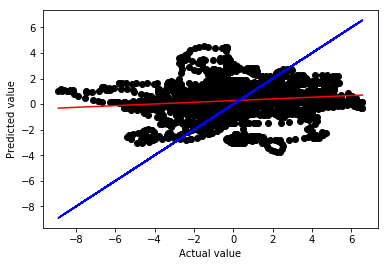


Displaying graph for dataseries 1:


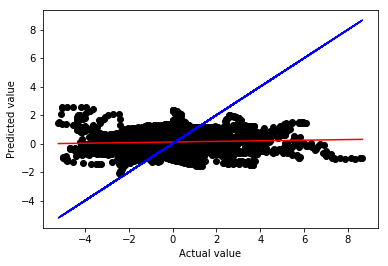


Displaying graph for dataseries 2:


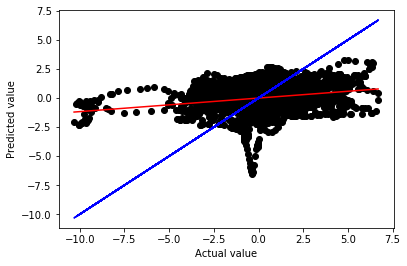


Displaying graph for dataseries 3:


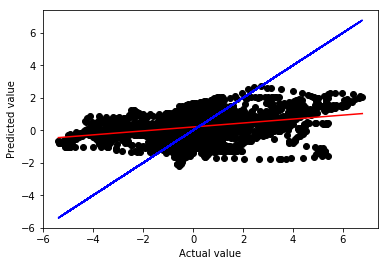


Displaying graph for dataseries 4:


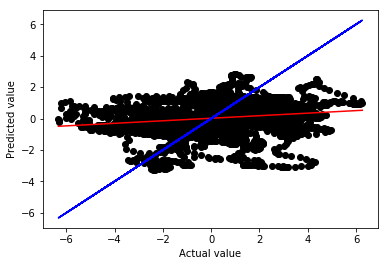


Displaying graph for dataseries 5:


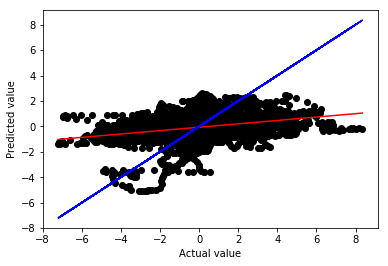


Displaying graph for dataseries 6:


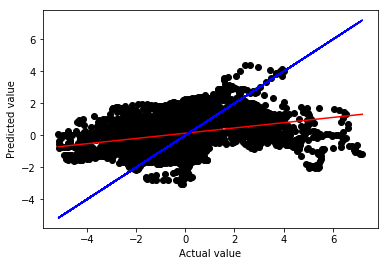


Displaying graph for dataseries 7:


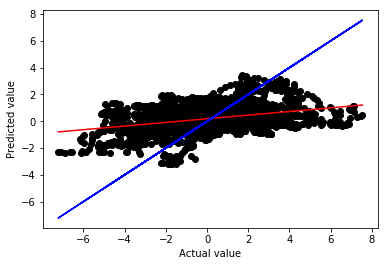


Displaying graph for dataseries 8:


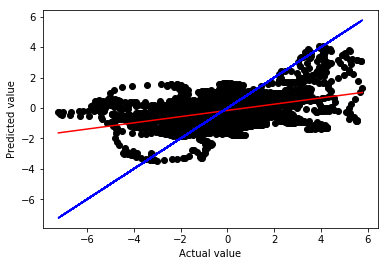


Displaying graph for dataseries 9:


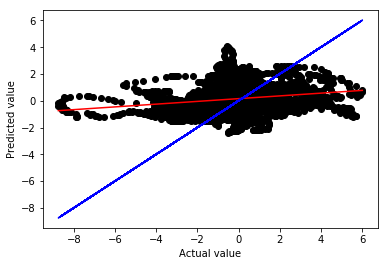

In [20]:
train_model(n_epochs=100,display_step=20,learning_rate=0.01, restore_from_save=False)

INFO:tensorflow:Restoring parameters from ModelCheckpoints/five_fish_xy-embed_128-relu_2x256-l2_norm-pred_five_fish_delta_xy.ckpt
Model successfully restored from ModelCheckpoints/five_fish_xy-embed_128-relu_2x256-l2_norm-pred_five_fish_delta_xy.ckpt.
Resuming training.
Epoch 0, Minibatch cost = 4.091207
Epoch 0, Validation set cost = 4.111395
Epoch 20, Minibatch cost = 3.900789
Epoch 20, Validation set cost = 3.935203
Epoch 40, Minibatch cost = 3.766125
Epoch 40, Validation set cost = 3.777492
Epoch 60, Minibatch cost = 3.557331
Epoch 60, Validation set cost = 3.622679
Epoch 80, Minibatch cost = 3.484483
Epoch 80, Validation set cost = 3.554501
Epoch 100, Minibatch cost = 3.453054
Epoch 100, Validation set cost = 3.499400
Epoch 120, Minibatch cost = 3.327154
Epoch 120, Validation set cost = 3.444238
Epoch 140, Minibatch cost = 3.293108
Epoch 140, Validation set cost = 3.420960
Epoch 160, Minibatch cost = 3.258794
Epoch 160, Validation set cost = 3.383316
Epoch 180, Minibatch cost = 3.

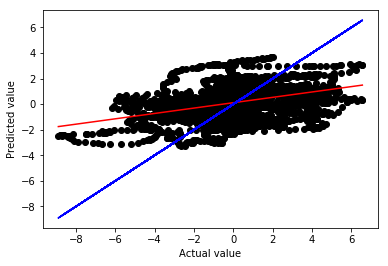


Displaying graph for dataseries 1:


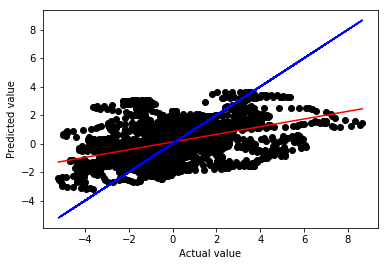


Displaying graph for dataseries 2:


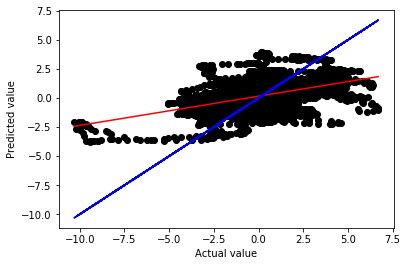


Displaying graph for dataseries 3:


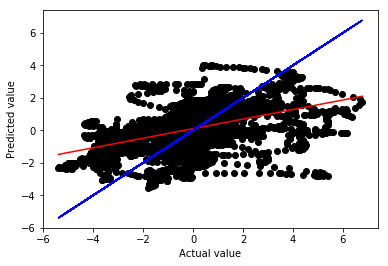


Displaying graph for dataseries 4:


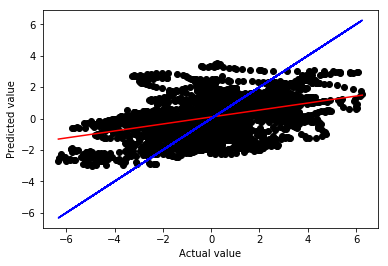


Displaying graph for dataseries 5:


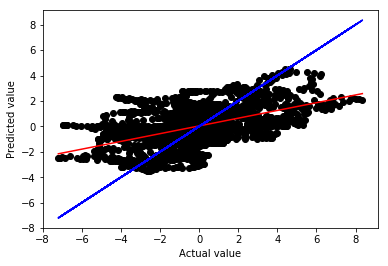


Displaying graph for dataseries 6:


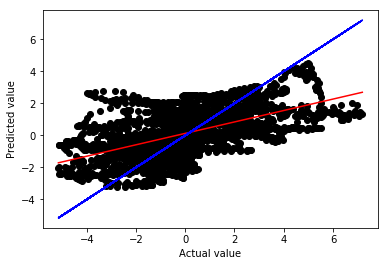


Displaying graph for dataseries 7:


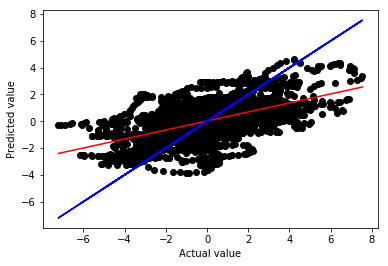


Displaying graph for dataseries 8:


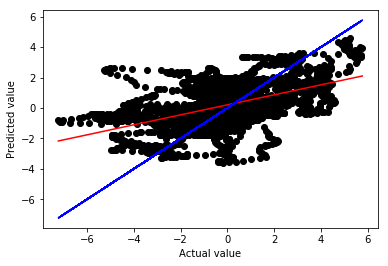


Displaying graph for dataseries 9:


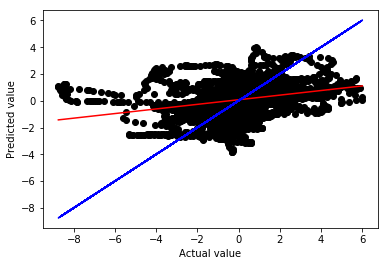

In [21]:
train_model(n_epochs=500,display_step=20,learning_rate=0.0001, restore_from_save=True)

In [22]:
# Generate and save simulated fish data
savefile = 'ModelOutputs/five_fish_xy-embed_128-relu_2x256-l2_norm-predict_five_fish_delta_xy-5000_steps.csv'
seed = x_valid[0]  # select a seed from the validation data
pred = generate_prediction(seed, prediction_length=5000, restore_path=model_path, progress_counter=40)
np.savetxt(savefile, pred, delimiter=',')

INFO:tensorflow:Restoring parameters from ModelCheckpoints/five_fish_xy-embed_128-relu_2x256-l2_norm-pred_five_fish_delta_xy.ckpt
Model successfully restored from ModelCheckpoints/five_fish_xy-embed_128-relu_2x256-l2_norm-pred_five_fish_delta_xy.ckpt.
Generating sequence.
Generated 0 of 5000 data points.
Generated 125 of 5000 data points.
Generated 250 of 5000 data points.
Generated 375 of 5000 data points.
Generated 500 of 5000 data points.
Generated 625 of 5000 data points.
Generated 750 of 5000 data points.
Generated 875 of 5000 data points.
Generated 1000 of 5000 data points.
Generated 1125 of 5000 data points.
Generated 1250 of 5000 data points.
Generated 1375 of 5000 data points.
Generated 1500 of 5000 data points.
Generated 1625 of 5000 data points.
Generated 1750 of 5000 data points.
Generated 1875 of 5000 data points.
Generated 2000 of 5000 data points.
Generated 2125 of 5000 data points.
Generated 2250 of 5000 data points.
Generated 2375 of 5000 data points.
Generated 2500 of